# CycleGAN

In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(device)

batch_size = 2


cpu


In [2]:
!pip install kaggle

In [3]:
#Downloading dataset from kaggle
import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}
print(kaggle_apikey) 

base_dir = '/home/azureuser/'
kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir[0])
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
! chmod 600 {kaggle_dir}/kaggle.json

{'username': 'jamesdavey', 'key': 'a8975caa44cfa08d6f2164f2d5977b6e'}
base_dir: /
kaggle_dir: /home/azureuser/.kaggle


In [4]:
# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print(f.read())

{"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


number of images: 9877 ['1.png', '10.png', '100.png', '1000.png', '1001.png']


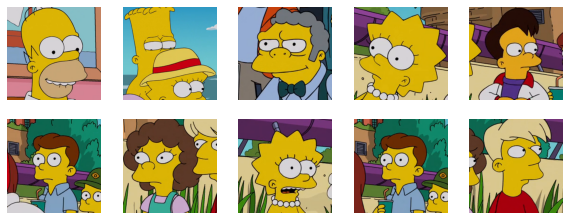

In [27]:
# ! kaggle datasets download -d kostastokis/simpsons-faces
# #unzip file simpsons-faces.zip
# with zipfile.ZipFile("simpsons-faces.zip","r") as zip_ref:
#     zip_ref.extractall("simpsons-data")

import os
simpson_file_paths = sorted(os.listdir('simpsons-data/cropped'))
print("number of images:", len(simpson_file_paths), simpson_file_paths[:5])
# display 10 images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('simpsons-data/cropped/'+simpson_file_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [7]:
# ! kaggle datasets download -d atulanandjha/lfwpeople
# with zipfile.ZipFile("lfwpeople.zip","r") as zip_ref:
#     zip_ref.extractall()

# import tarfile
# tar = tarfile.open("lfw-funneled.tgz")
# tar.extractall()
# tar.close()

 97%|██████████████████████████████████████▊ | 225M/232M [00:10<00:00, 37.6MB/s]
100%|████████████████████████████████████████| 232M/232M [00:13<00:00, 17.9MB/s]


In [3]:
!ls 

Users  face-data  lfw_funneled	 simpsons-data
data   generated  lfwpeople.zip  simpsons-faces.zip


In [23]:
names = sorted(os.listdir('lfw_funneled'))
print("number of people:", len(names), names[:5])

faces_file_paths = []
counter= 0 
for name in names:
    images_in_folder = os.listdir('lfw_funneled/'+name)
    faces_file_paths.extend([name+"/"+x for x in images_in_folder[:2]])
    counter += 1
    if counter > 1000: break # Deleted this line to get all the images

print("number of images:", len(faces_file_paths), faces_file_paths[:5])

number of images: 1295 ['AJ_Cook/AJ_Cook_0001.jpg', 'AJ_Lamas/AJ_Lamas_0001.jpg', 'Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 'Aaron_Guiel/Aaron_Guiel_0001.jpg', 'Aaron_Patterson/Aaron_Patterson_0001.jpg']


[1005  277  292  574  921   55 1004 1109    4   66]


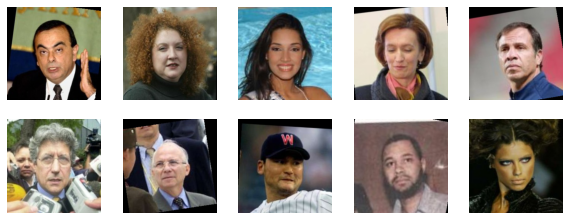

In [26]:
# 10 random numbers in range 0 to len(faces_file_paths)
random_indices = np.random.randint(0, len(faces_file_paths), 10)
print(random_indices)
# display 10 images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('lfw_funneled/'+ faces_file_paths[random_indices[i]])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [141]:
#Create traindataloader from simpsons dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, file_paths, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = file_paths
        self.len = len(self.file_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = plt.imread(self.root_dir + self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

# faces_mean = 0.0
# faces_std = 0.0
# for img in faces_dataset:
#     faces_mean+=img.mean([1,2])
#     faces_std+=img.std([1,2])
# faces_mean = faces_mean/len(faces_dataset)
# faces_std = faces_std/len(faces_dataset)
# print(faces_mean, faces_std)

# simpsons_mean = 0.0
# simpsons_std = 0.0
# for img in simpsons_dataset:
#     simpsons_mean+=img.mean([1,2])
#     simpsons_std+=img.std([1,2])
    
# simpsons_mean = simpsons_mean/len(simpsons_dataset)
# simpsons_std = simpsons_std/len(simpsons_dataset)
# print(simpsons_mean, simpsons_std)
    
faces_mean, faces_std = (0.4339, 0.3770, 0.3373), (0.2682, 0.2454, 0.2354)
simp_mean, simp_std = (0.6018, 0.5183, 0.2937), (0.2526, 0.2123, 0.2660)

faces_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(faces_mean, faces_std)])
simp_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(simp_mean, simp_std)])

#transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),

print(len(simpson_file_paths), len(faces_file_paths))
max_length = min(len(simpson_file_paths), len(faces_file_paths))
print(max_length)

faces_dataset = CustomDataset('lfw_funneled/', faces_file_paths[:max_length], transform=faces_transforms)
simpsons_dataset = CustomDataset('simpsons-data/cropped/', simpson_file_paths[:max_length], transform=simp_transforms)

# create dataloaders
faces_dataloader = torch.utils.data.DataLoader(faces_dataset, batch_size=batch_size, shuffle=True)
simpsons_dataloader = torch.utils.data.DataLoader(simpsons_dataset, batch_size=batch_size, shuffle=True)
print("simpsons_dataloader:", len(simpsons_dataloader), "faces_dataloader:", len(faces_dataloader), "batches of size", batch_size)


9877 1295
1295
simpsons_dataloader: 648 faces_dataloader: 648 batches of size 2


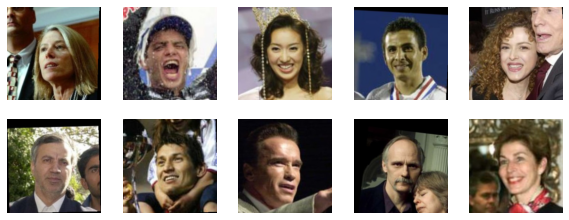

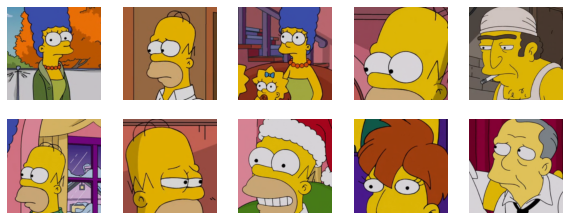

In [186]:
inv_transformation_face = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = ([1/s for s in faces_std])),
                                                transforms.Normalize(mean = [ -m for m in faces_mean ],
                                                                    std = [ 1., 1., 1. ])])
inv_transformation_simp = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = ([1/s for s in simp_std])),     
                                                  transforms.Normalize(mean = [ -m for m in simp_mean ],
                                                                        std = [ 1., 1., 1. ])])

# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(faces_dataloader):
    for j in range(batch_size):
        plt.subplot(5,5,i*batch_size+j+1)
        image = inv_transformation_face(batch[j])
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i == 4: break
plt.show()

# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(simpsons_dataloader):
    for j in range(batch_size):
        plt.subplot(5,5,i*batch_size+j+1)
        img = inv_transformation_simp(batch[j])
        image = inv_transformation_simp(batch[j])
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i == 4: break
plt.show()

In [155]:
image.max(), image.min()

(tensor(0.8967), tensor(-0.2221))

Generating fake simpsons images (from faces)...


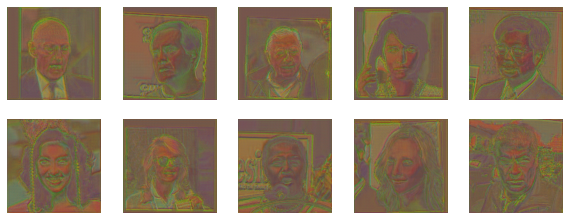

Generating fake faces images (from simpsons)...


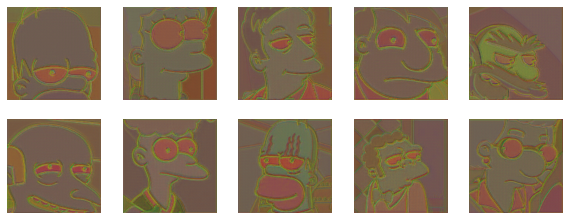

In [192]:
def display_generated_images(G, F):

    print("Generating fake simpsons images (from faces)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(faces_dataloader):
        for j in range(batch_size):
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(G(batch[j].unsqueeze(dim=0).to(device)).cpu().detach())
            plt.imshow(image.squeeze(dim=0).clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i == 4: break
    plt.show()

    print("Generating fake faces images (from simpsons)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(simpsons_dataloader):
        for j in range(batch_size):
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(G(batch[j].unsqueeze(dim=0).to(device)).cpu().detach())
            plt.imshow(image.squeeze(dim=0).clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i == 4: break
    plt.show()

display_generated_images(G, F)

## Models

In [ ]:
# Information:
# X is a dataset of human faces
# Y is a dataset of simpsons faces

# G: X -> Y, F: Y -> X
# D: Y -> [0,1], D': X -> [0,1]

### Defining Model Classes

In [193]:
###############################################################################
# Models
###############################################################################


class DoubleConv(nn.Module):
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
      
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)

    nn.init.normal_(conv1.weight, mean=0.0, std= (2/(9*input_channels))**(1/2)) #sqrt(2/N)
    nn.init.normal_(conv2.weight, mean=0.0, std= (2/(9*output_channels))**(1/2)) 
    
    self.conv = nn.Sequential(conv1, nn.BatchNorm2d(output_channels), nn.ReLU(),
                              conv2, nn.BatchNorm2d(output_channels), nn.ReLU())
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  MaxPool, DoubleCov
  MaxPool, Conv, BatchNorm, ReLU, Conv, BatchNorm, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.

    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(self.max_pool(x))

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Upsample, Conv, Concat, Conv, ReLU, Conv, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) -- input tensor to block
      res (torch.Tensor) -- residual connection feeding into block
    
    Return x
    x will be used as the input to the next upsizing block (or final layer)
    """
    x = self.up_sample(x)
    # size_diff1 = (res.shape[2]-x.shape[2])//2
    # size_diff2 = (res.shape[2]-x.shape[2]) - size_diff1
    # x = torch.concat((x, res[:, :, size_diff1:-size_diff2, size_diff1:-size_diff2]), dim = 1)
    x = torch.cat((x, res), dim = 1)
    x = self.conv(x)
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 3):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      channels_in (int) -- input images channel size
    """
    super().__init__()
    self.first_conv = DoubleConv(channels_in, 64)
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c, 2*c) for c in [64, 128, 256, 512]])
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(2*c, c) for c in [512, 256, 128, 64]])
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=channels_in, kernel_size=1, stride=1, padding=0)
    self.tanh = nn.Tanh()
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) --input tensor to block
      targets (torch.Tensor) --target output of model

    Returns (logits, loss)

    logits (torch.Tensor) --model's raw output
    loss (torch.float32) --2d CrossEntropyLoss result
    """
    x = self.first_conv(x)
    residuals = []
    for downsample in self.downsample_blocks:
      residuals.append(x)
      x = downsample(x)
    for i, upsample in enumerate(self.upsample_blocks):
      x = upsample(x, residuals[-(i+1)])
    x = self.final_layer(x)
    return self.tanh(x)
  
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, 
                input_channels: int = 3):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        x = self.flatten(x)
        return torch.mean(x, dim=1)

# input = torch.randn(5, 3, 256, 256)
# D = Discriminator()
# print(D(input).shape)

# x = torch.randn(5, 3, 256, 256)
# model = UNET()
# print(model(x)[0].shape)

In [195]:
G = UNET().to(device)
F = UNET().to(device)

D_y = Discriminator().to(device)
D_x = Discriminator().to(device)

faces = next(iter(faces_dataloader)).to(device)
simpsons = next(iter(simpsons_dataloader)).to(device)

print(faces.shape, simpsons.shape)
print(G(faces).shape, F(simpsons).shape)
print(D_y(faces).shape, D_y(G(faces)).shape)
print(D_x(simpsons).shape, D_x(F(simpsons)).shape)

torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])
torch.Size([2]) torch.Size([2])
torch.Size([2]) torch.Size([2])


In [198]:
def zero_all_grads():
    G.zero_grad()
    F.zero_grad()
    D_y.zero_grad()
    D_x.zero_grad()

################## Hyperparameters ##################
epochs = 100
learning_rate = 0.0002

l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()

################## Training loop ##################
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
F_optimizer = torch.optim.Adam(F.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_y_optimizer = torch.optim.Adam(D_y.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_x_optimizer = torch.optim.Adam(D_x.parameters(), lr=learning_rate, betas=(0.5, 0.999))

for epoch in range(epochs):
    for batch_idx, (faces, simpsons) in enumerate(zip(faces_dataloader, simpsons_dataloader)):
        B, C, H, W = faces.shape
        real_labels = torch.ones(B).to(device)
        fake_labels = torch.zeros(B).to(device)

        ########## Train Discriminators Y ##########
        #Minimizing adversarial loss
        
        ## D_y ##
        #Minimizing D_y for (D_y(x) - 1)^2 + (D_y(G(x)) - 0)^2
        simpsons_pred_real = D_y(simpsons)
        simpsons_pred_fake = D_y(G(faces))
        D_y_loss = l2_loss_fn(simpsons_pred_real, real_labels) + l2_loss_fn(simpsons_pred_fake, fake_labels)
        zero_all_grads()
        D_y_loss.backward()
        D_y_optimizer.step()

        ## D_x ##
        #Minimizing D_y for (D_x(x) - 1)^2 + (D_x(G(x)) - 0)^2
        faces_pred_real = D_y(faces)
        faces_pred_fake = D_y(G(simpsons))
        D_x_loss = l2_loss_fn(faces_pred_real, real_labels) + l2_loss_fn(faces_pred_fake, fake_labels)
        zero_all_grads()
        D_x_loss.backward()
        D_x_optimizer.step()

        
        ########## Train Generators ############
       
        ## G ##
        #Minimizing G for (D_y(G(x)) - 1)^2
        generated_images_g = G(faces) # would normally use random noise here instead of faces
        pred_labels_g = D_y(generated_images_g)
        generator_loss_g = l2_loss_fn(pred_labels_g, real_labels)

        #Cycle consistency loss
        generated_images_g_f = F(generated_images_g)
        cycle_consistency_loss_g = l1_loss_fn(generated_images_g_f, faces)
        
        loss_g = generator_loss_g + cycle_consistency_loss_g
        zero_all_grads()
        loss_g.backward()
        G_optimizer.step()

        ## F ##
        #Minimizing F for (D_x(F(x)) - 1)^2
        generated_images_f = F(simpsons)
        pred_labels_f = D_x(generated_images_f)
        generator_loss_f = l2_loss_fn(pred_labels_f, real_labels)

        #Cycle consistency loss
        generated_images_f_g = G(generated_images_f)
        cycle_consistency_loss_f = l1_loss_fn(generated_images_f_g, simpsons)

        loss_f = generator_loss_f + cycle_consistency_loss_f
        zero_all_grads()
        loss_f.backward()
        F_optimizer.step()
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(faces_dataloader)} \
                  Loss D_y: {D_y_loss:.4f}, Loss D_x: {D_x_loss:.4f} loss G: {loss_g:.4f}, loss F: {loss_f:.4f}")
    

Epoch [0/100] Batch 0/648                   Loss D_y: 0.4080, Loss D_x: 0.4671 loss G: 1.6867, loss F: 1.2098
Epoch [0/100] Batch 10/648                   Loss D_y: 0.5511, Loss D_x: 0.6402 loss G: 1.1102, loss F: 1.0307


## Model architecture

In [ ]:
# Able to train on up-paired training data
#Translate an image from target to source domain

#Generator G horses -> zebras
#adversarial loss

#Inverse mapping F, zebras -> horses
#cycle consitency loss

# X is a set of horses
# Y is a set of zebras

# G: X -> Y
# F: Y -> X

# Adversarial Loss:
#Discriminator D_Y classifies if an generated zebra is real or fake
#Discriminator D_X classifies if an generated horse is real or fake

# Forward Cycle Consistency Loss:
# X_hat = F(G(X))
# want to minimize ||X - X_hat|| (L1 loss)

# Backward Cycle Consistency Loss:
# Y_hat = G(F(Y))
# want to minimize ||Y - Y_hat|| (L1 loss)


# Adversarial Loss:
#Loss_D(G, D_Y, X, Y) = -E[log(D_Y(Y))] - E[log(1 - D_Y(G(X)))]

#Cycle Consistency Loss:
#Loss_cyc(G, F, X, Y) = E||X - F(G(X))|| + E||Y - G(F(Y))|| (L1 Loss)

# Full Objective:
#Loss(G, F, D_X, D_Y, X, Y) = Loss_D(G, D_Y, X, Y) + Loss_D(F, D_X, Y, X) + lambda * Loss_cyc(G, F, X, Y)

# Network Architecture:

# Discriminator: network classifies if 70x70 patch is real or fake
# generating a grid

# Train G to minimize
# (D(G(x)) - 1)^2
# Train D to minimize
# (D(y)-1)^2 + D(G(x))^2

#batch size = 1
# lambda = 10
# lr = 0.0002 with Adam optimizer
#keep learning rate constant for 100 epochs,
#then linearly decay to 0 over next 100 epochs